<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/dev_branch/DEEPFAKE_AUDIO_DETECTION_TRANSFER_LEARNING_MODELS_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inception V3 model 



## Importing neccesary libraries. 

In [1]:
!pip install wandb

In [2]:
# import necessary libraries
import wandb
from wandb.keras import WandbCallback
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os
from PIL import Image


from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
K.clear_session()
import itertools

import cv2
import matplotlib.cm as cm

from tensorflow.keras.utils import to_categorical


import tensorflow as tf

import numpy as np
from tqdm import tqdm
import math
import os



## Initialize WandB

In [4]:
# Initialize wandb
wandb.login()
wandb.init(project='DeepFake Audio Detection', entity='ruoro' , save_code= True, 
           config = {
               'learning_rate': 0.001,
               'epochs': 5,
               'batch_size': 4,
               'loss_function':"binary_crossentropy"
           }
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ruoro (use `wandb login --relogin` to force relogin)


## Mount Google Drive

In [5]:
#Mount google drive to access data

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Load Data and Modelling

In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# define train and test data
train_path ='/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train'
test_path = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test'


In [7]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [8]:
# add preprocessing layer to the front of Inception
# the include_top false statement will allow us to be able to set the number of classes on the top layer that we will create
incept = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train - incept has existing weights
for layer in incept.layers:
  layer.trainable = False
  


87916544/87910968 [==============================] - 1s 0us/step


In [9]:
  # useful for getting number of classes
  # this will count the number of classes we have in our dataset assuming that the data is grouped into specific folders
from glob import glob
folders = glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/*')

In [10]:
# our layers
x = Flatten()(incept.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='sigmoid')(x)

# #adding the output layer
# cnn.add(tf.keras.layers.Dense(units = 1 , activation = 'sigmoid'))


In [11]:

# create a model object
model = Model(inputs=incept.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# tell the model what cost and optimization method to use

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate= 0.001)


model.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)




In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 5,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/',
                                            target_size = (224, 224),
                                            batch_size = 5,
                                            class_mode = 'categorical')



Found 1650 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

In [15]:
# Early stopping Callback 
estp = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode="max", patience= 3)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=0.00001, mode='min')


In [16]:
# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=20,
  validation_steps=20,
  callbacks=[estp, reduce_lr_loss, WandbCallback()] 
)


Epoch 1/30
20/20 [==============================] - 65s 3s/step - loss: 1.1306 - accuracy: 0.5800 - val_loss: 1.2366 - val_accuracy: 0.5200
Epoch 2/30
20/20 [==============================] - 47s 2s/step - loss: 1.1050 - accuracy: 0.5300 - val_loss: 1.1743 - val_accuracy: 0.5500
Epoch 3/30
20/20 [==============================] - 42s 2s/step - loss: 1.0986 - accuracy: 0.5900 - val_loss: 1.2761 - val_accuracy: 0.5200
Epoch 4/30
20/20 [==============================] - 36s 2s/step - loss: 1.1354 - accuracy: 0.5400 - val_loss: 0.9234 - val_accuracy: 0.6000
Epoch 5/30
20/20 [==============================] - 36s 2s/step - loss: 1.1033 - accuracy: 0.5700 - val_loss: 1.1866 - val_accuracy: 0.5200
Epoch 6/30
20/20 [==============================] - 34s 2s/step - loss: 1.0034 - accuracy: 0.6100 - val_loss: 0.9947 - val_accuracy: 0.5500
Epoch 7/30
20/20 [==============================] - 29s 1s/step - loss: 0.9678 - accuracy: 0.6500 - val_loss: 1.0675 - val_accuracy: 0.5300

Epoch 00007: Reduce

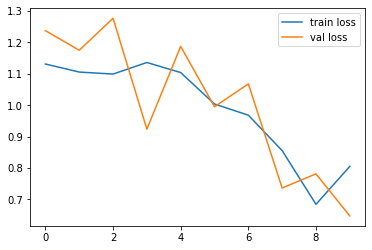

<Figure size 432x288 with 0 Axes>

In [17]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

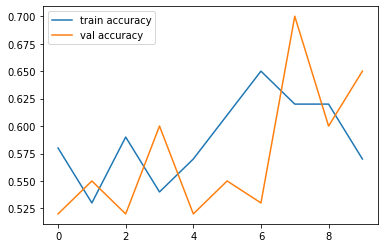

<Figure size 432x288 with 0 Axes>

In [18]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('InceptionV3.h5')

### Learning Rate scheduler

In [21]:
from tensorflow.keras.optimizers import Ftrl
# Learning Rate scheduler Callback
def scheduler(epoch, lr):
   if epoch < 5:
     return lr
   else:
     return lr * tf.math.exp(-0.01)

In [24]:
 lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [25]:
# fit the model
r2 = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=20,
  validation_steps=20,
  callbacks=[estp, lrScheduler, WandbCallback()] 
)


Epoch 1/20
20/20 [==============================] - 29s 1s/step - loss: 0.5452 - accuracy: 0.7200 - val_loss: 0.8258 - val_accuracy: 0.6200
Epoch 2/20
20/20 [==============================] - 23s 1s/step - loss: 0.6338 - accuracy: 0.6800 - val_loss: 0.5769 - val_accuracy: 0.7500
Epoch 3/20
20/20 [==============================] - 25s 1s/step - loss: 0.6764 - accuracy: 0.6700 - val_loss: 0.6522 - val_accuracy: 0.6400
Epoch 4/20
20/20 [==============================] - 26s 1s/step - loss: 0.7224 - accuracy: 0.6400 - val_loss: 0.6344 - val_accuracy: 0.6800


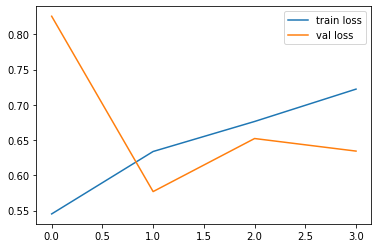

<Figure size 432x288 with 0 Axes>

In [26]:
# loss
plt.plot(r2.history['loss'], label='train loss')
plt.plot(r2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

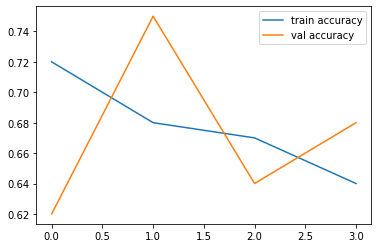

<Figure size 432x288 with 0 Axes>

In [27]:
# accuracies
plt.plot(r2.history['accuracy'], label='train accuracy')
plt.plot(r2.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [28]:
# Ftrl optimizer
from tensorflow.keras.optimizers import Ftrl
opt2 = tf.keras.optimizers.Ftrl(
    learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1,
    l1_regularization_strength=0.0, l2_regularization_strength=0.0,
    name='Ftrl'
    )

In [29]:
# Compile model
model.compile(
  loss='binary_crossentropy',
  optimizer=opt2,
  metrics=['accuracy']
)


In [ ]:
# fit the model
r3 = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=20,
  validation_steps=20,
  callbacks=[estp, WandbCallback()] 
)


In [30]:
# loss
plt.plot(r3.history['loss'], label='train loss')
plt.plot(r3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

NameError: ignored

In [ ]:
# accuracies
plt.plot(r3.history['accuracy'], label='train accuracy')
plt.plot(r3.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')